In [2]:
! pip install mplcyberpunk


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
from scipy.sparse import coo_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import warnings

warnings.filterwarnings('ignore')

In [4]:
movies = pd.read_csv(r'C:\Users\veeraj\OneDrive\Desktop\ml-20m\movies.csv')
ratings = pd.read_csv(r'C:\Users\veeraj\OneDrive\Desktop\ml-20m\ratings.csv')
tags = pd.read_csv(r'C:\Users\veeraj\OneDrive\Desktop\ml-20m\tags.csv')

In [5]:
sampled_user_ids = ratings['userId'].drop_duplicates().sample(frac=0.9, random_state=42)
trimmed_ratings = ratings[ratings['userId'].isin(sampled_user_ids)]

In [6]:
movie_ratings_count = trimmed_ratings.groupby('movieId').size()
popular_movies = movie_ratings_count[movie_ratings_count >= 100].index
trimmed_ratings = trimmed_ratings[trimmed_ratings['movieId'].isin(popular_movies)]

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
trimmed_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [9]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [10]:
# Performing some basic EDA

In [11]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [12]:
trimmed_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [13]:
tags.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

In [14]:
eda = pd.merge(movies, trimmed_ratings, on='movieId')

In [15]:
eda.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,944919407
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,833981871
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,943497887
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,1230858821
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,4.0,859063718


In [16]:
eda.shape

(17690667, 6)

In [17]:
eda.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Shawshank Redemption, The (1994)    4.446260
Godfather, The (1972)               4.364158
Usual Suspects, The (1995)          4.334196
Schindler's List (1993)             4.310361
Godfather: Part II, The (1974)      4.274692
Name: rating, dtype: float64

In [18]:
eda_rating = pd.DataFrame(eda.groupby('title')['rating'].mean())

In [19]:
eda_rating.head()

,rating
title,
"""Great Performances"" Cats (1998)",2.765517
'Round Midnight (1986),3.642857
'Salem's Lot (2004),3.076271
'Til There Was You (1997),2.846072
"'burbs, The (1989)",3.058966


In [20]:
eda_rating['rating_count'] = pd.DataFrame(eda.groupby('title')['rating'].mean())

<Axes: >

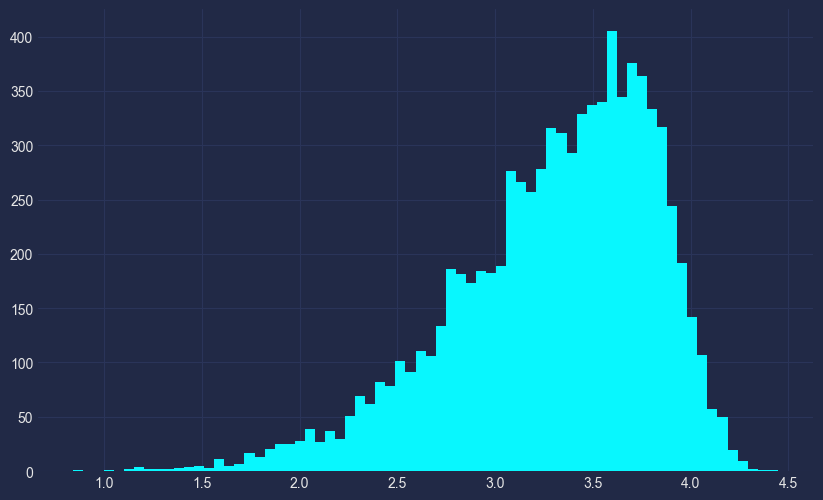

In [21]:
plt.style.use('cyberpunk')
plt.figure(figsize=(10,6))
eda_rating['rating_count'].hist(bins=70)

<Figure size 1000x600 with 0 Axes>

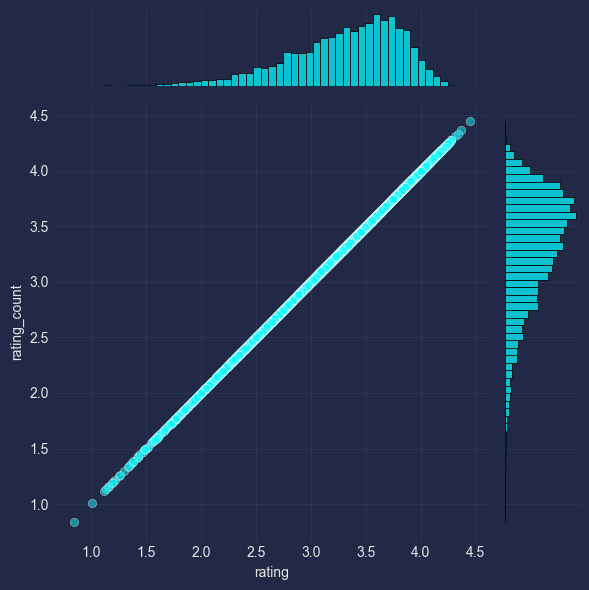

In [22]:
plt.style.use('cyberpunk')
plt.figure(figsize=(10,6))
sns.jointplot(x='rating', y='rating_count', data=eda_rating, alpha=0.5)

In [23]:
# Popularity Base:

In [24]:
ratings_avg = trimmed_ratings.groupby('movieId').agg({'rating': ['mean', 'count']}).reset_index()

In [25]:
ratings_avg.columns = ['movieId', 'mean_rating', 'rating_count']

In [26]:
popularity_data = pd.merge(movies, ratings_avg, on='movieId')

In [27]:
most_popular_movies = popularity_data.sort_values(by='rating_count', ascending=False).head(10)

In [28]:
print('\nMost Popular Movies:\n')
print(most_popular_movies[['title', 'mean_rating', 'rating_count']])


Most Popular Movies:

                                          title  mean_rating  rating_count
271                         Pulp Fiction (1994)     4.172575         60539
329                         Forrest Gump (1994)     4.029175         59504
292            Shawshank Redemption, The (1994)     4.446260         57043
542            Silence of the Lambs, The (1991)     4.176122         56986
440                        Jurassic Park (1993)     3.663183         53774
237   Star Wars: Episode IV - A New Hope (1977)     4.190973         49041
102                           Braveheart (1995)     4.043766         48428
539           Terminator 2: Judgment Day (1991)     3.931370         47020
2125                         Matrix, The (1999)     4.187319         46194
487                     Schindler's List (1993)     4.310361         45017


<module 'matplotlib.pyplot' from 'c:\\Users\\veeraj\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

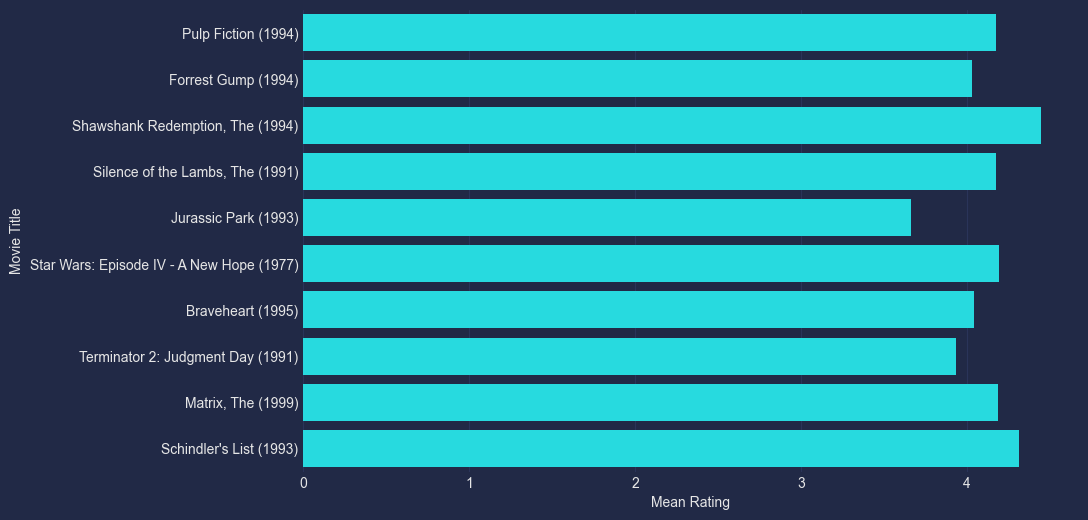

In [29]:
plt.style.use('cyberpunk')
plt.figure(figsize=(10,6))
sns.barplot(x='mean_rating', y='title', data=most_popular_movies, orient='h')
plt.xlabel('Mean Rating')
plt.ylabel('Movie Title')
plt

In [30]:
# Content-Base:

In [31]:
tags.dropna(subset=['tag'], inplace=True)
movies_tags = pd.merge(movies, tags[['movieId', 'tag']], on='movieId', how='left')
movies_tags['tag'] = movies_tags['tag'].fillna('')
movies_tags = movies_tags.groupby('movieId').agg({'title': 'first','tag': lambda x: ' '.join(x)}).reset_index()

In [32]:
movies_tags.head()

,movieId,title,tag
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Diane Keaton family sequel Steve Martin weddin...


In [33]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

In [34]:
tags['tag']

0           Mark Waters
1             dark hero
2             dark hero
3         noir thriller
4             dark hero
              ...      
465559          dragged
465560    Jason Bateman
465561           quirky
465562              sad
465563    rise to power
Name: tag, Length: 465548, dtype: object

In [35]:
tfidf_vect = tfidf.fit_transform(movies_tags['tag'])

In [36]:
print(tfidf_vect.shape)

(27278, 5000)


In [37]:
# Truncated SVD

In [38]:
svd = TruncatedSVD(n_components=500, random_state=42)

In [39]:
latent_matrix = svd.fit_transform(tfidf_vect)

In [40]:
print('Shape of latent matrix:', latent_matrix.shape)

Shape of latent matrix: (27278, 500)


In [41]:
consin_matrix = cosine_similarity(latent_matrix)

In [42]:
movie_indices = pd.Series(movies_tags.index, index=movies_tags['title'].str.lower()).drop_duplicates()

def recommend_movies(title, cosine_sim=consin_matrix, n_recommendations=10):
        idx = movie_indices.get(title.lower()) 
        if idx is None:
            return "Movie title not found. Please check the title."
        scores_sim = list(enumerate(cosine_sim[idx]))
        scores_sim = sorted(scores_sim, key=lambda x: x[1], reverse=True)
        sim_indices = [i[0] for i in scores_sim[1:n_recommendations+1]]
        return movies_tags['title'].iloc[sim_indices].tolist()

print(recommend_movies('Toy Story (1995)'))

['Toy Story 2 (1999)', "Bug's Life, A (1998)", 'Monsters, Inc. (2001)', 'Ice Age (2002)', 'Finding Nemo (2003)', 'Ratatouille (2007)', 'Toy Story 3 (2010)', 'Incredibles, The (2004)', 'Up (2009)', 'Antz (1998)']


In [43]:
# collaborative 

In [44]:
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

In [45]:
user_ids = trimmed_ratings['userId'].astype('category').cat.codes
movie_ids = trimmed_ratings['movieId'].astype('category').cat.codes
ratings = trimmed_ratings['rating'].values

In [46]:
user_movie_sparse_matrix = coo_matrix((ratings, (user_ids, movie_ids)))
user_movie_sparse_matrix = user_movie_sparse_matrix.tocsr()

In [54]:
# Matrix Factorization Using SVD

In [47]:
user_ratings_mean = np.mean(user_movie_sparse_matrix.toarray(), axis=1)
user_item_demeaned = user_movie_sparse_matrix - user_ratings_mean.reshape(-1, 1)
U, sigma, Vt = svds(user_item_demeaned, k=50)
sigma = np.diag(sigma)

In [48]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=np.unique(movie_ids))

In [49]:
# collaborative filtering

In [54]:
def recommend_collaborative(user_id, n_recommendations=10):
    if user_id not in user_ids.values:
        return "User ID not found."
    
    user_index = np.where(user_ids == user_id)[0][0]
    predicted_scores = pd.Series(predicted_ratings_df.iloc[user_index])
    
    movie_id_map = pd.Series(movies['title'].values, index=movies['movieId'].values)
    recommended_movie_ids = predicted_scores.sort_values(ascending=False).head(n_recommendations).index
    

    recommended_titles = [movie_id_map[rec_id] for rec_id in recommended_movie_ids]
    recommended_ratings = predicted_scores[recommended_movie_ids].values
    
    plt.style.use('cyberpunk')
    plt.figure(figsize=(10, 6))
    sns.barplot(x=recommended_ratings, y=recommended_titles, palette='coolwarm')
    plt.title(f"Collaborative Filtering Recommendations for User {user_id}", fontsize=16)
    plt.xlabel('Predicted Rating', fontsize=12)
    plt.ylabel('Movie Title', fontsize=12)
    plt.show()
    
    return recommended_titles


Collaborative Filtering Recommendations for User 1:


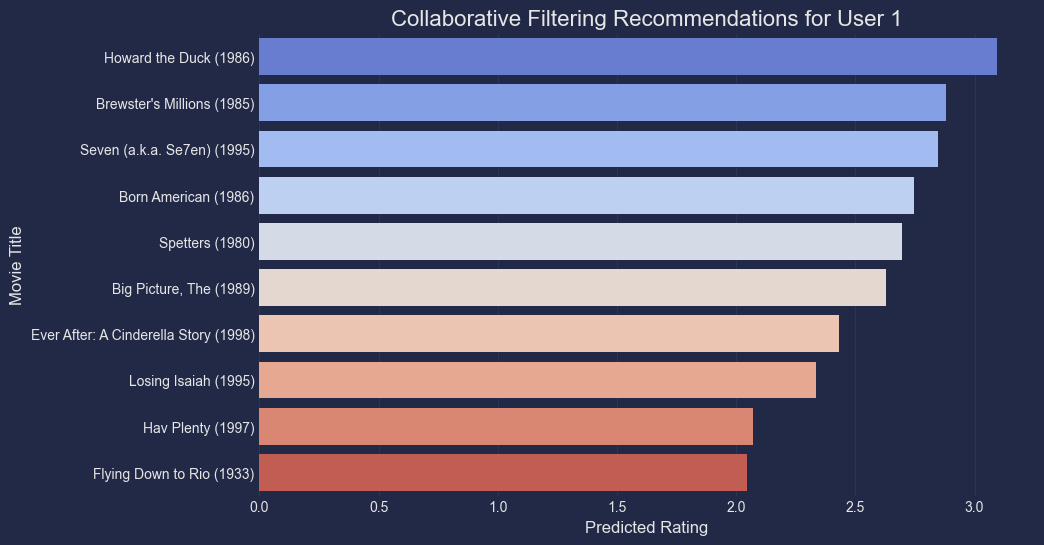

['Howard the Duck (1986)', "Brewster's Millions (1985)", 'Seven (a.k.a. Se7en) (1995)', 'Born American (1986)', 'Spetters (1980)', 'Big Picture, The (1989)', 'Ever After: A Cinderella Story (1998)', 'Losing Isaiah (1995)', 'Hav Plenty (1997)', 'Flying Down to Rio (1933)']


In [55]:
print("\nCollaborative Filtering Recommendations for User 1:")
print(recommend_collaborative(1))